In [69]:
#!/usr/bin/env python
import requests
from bs4 import BeautifulSoup as bs
import json
import re
import pandas as pd


class BitInfoChartsParser:
    def __init__(self, field:str, coin:str):
        self.field = field
        self.coin = coin
        self.url = f"https://bitinfocharts.com/comparison/{field}-{coin.lower()}.html#3y"
        self.article = requests.get(self.url)
        self.soup = bs(self.article.content, "html.parser")
        
    def get_data(self) -> pd.DataFrame:
        scripts = self.soup.findAll('script')
        for s in scripts:
            if s.text.startswith('var gIsLog = 0;'):
                break
        data = []
        for dt, val in re.findall(r"new Date\(\"([^\"]+)\"\),(\d+)", s.text):
            data.append({'date': dt, self.field: float(val)})
        df = pd.DataFrame(data)
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date')
        self.df = df[:-1].copy() # today's info is incomplete
        return self.df

In [126]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (16, 6)

def tweets_of(coin):
    bicp = BitInfoChartsParser('tweets', coin)
    df = bicp.get_data()
    df['tweets_index'] = df['tweets'].rolling(window=7).mean() / df['tweets'].rolling(window=100).mean()
    return df

def price_of(coin):
    bicp = BitInfoChartsParser('price', coin)
    df = bicp.get_data()
    df['price_index'] = df['price'] / df['price'].rolling(window=100).mean()
    return df

def analysis_of(coin):
    return price_of(coin).join(tweets_of(coin)).dropna()[
        ['price_index', 'tweets_index']][-3*365:].plot(legend='best', title=coin)

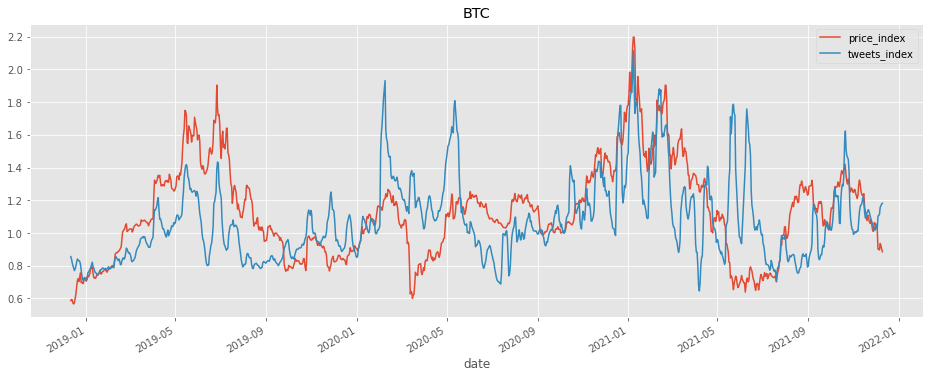

In [127]:
_ = analysis_of('BTC')

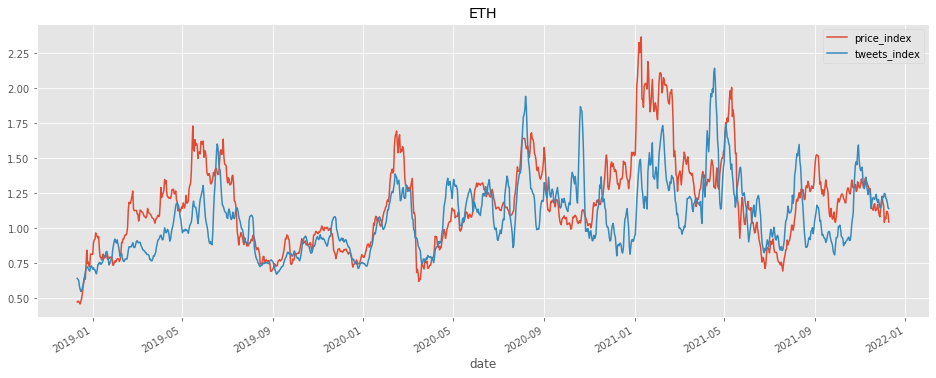

In [128]:
_ = analysis_of('ETH')

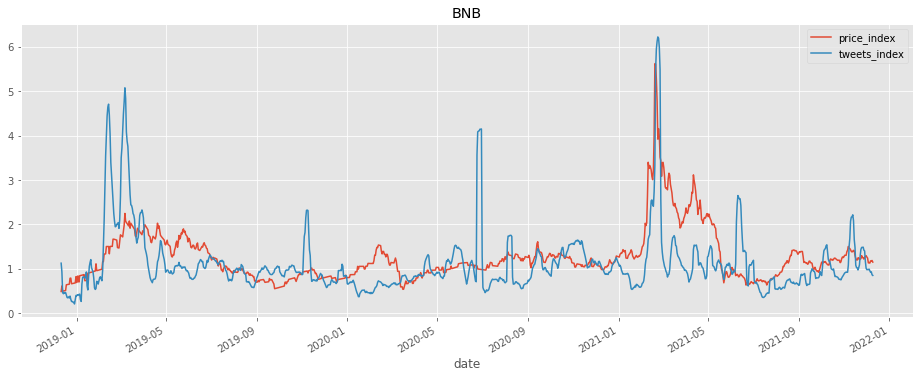

In [129]:
_ = analysis_of('BNB')

In [33]:
avail = {
    'tweets': [c.upper() for c in 'btc eth busd matic bnb link luna sol dot eos xrp ada okb xtz doge ltc '
               'btt fil shib trx mana sand usdc jst bch avax atom etc waxp near gala axs lrc xlm omg ust '
               'zec sushi bat ant uni icp ftm vet algo egld dydx enj cocos theta dash bsv chz'.split(' ')],
    'marketcap': [c.upper() for c in 'btc eth sol eos xrp ada xtz doge ltc btt fil trx jst bch atom etc '
                  'xlm zec dash bsv xmr ont iot sc dgb sys xvg btg rdd grs vtc block rtc ccx via etn xwc '
                  'pink etp emc2 lbc maid ppc ftc blk xdn vrc xst spc gld pot ioc'.split(' ')],
}